## EEP 153 Project 4

In this document we&rsquo;ll work through a simple approach to estimating
Constant Frisch Elasticity (CFE) demand systems. The goal of this project is to analyze the differences in diet within the population of Senegal based on household characteristics. After estimating a demand system for Senegal, we want to investigate the relationship between diet, budget, and prices.

There are two prerequisites; the first is the `CFEDemands` python
module.  The following code installs this module:

In [1]:
!pip install -r requirements.txt

  Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl (45 kB)
Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl (12 kB)
Using cached eep153_tools-0.12.4-py2.py3-none-any.whl (4.9 kB)
Using cached python_gnupg-0.5.4-py2.py3-none-any.whl (21 kB)
Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Attempting uninstall: gspread_pandas
    Found existing installation: gspread-pandas 2.2.3
    Uninstalling gspread-pandas-2.2.3:
      Successfully uninstalled gspread-pandas-2

The second prerequisite is a dataset including detailed information on
household expenditures and characteristics.  The structure of that
dataset is detailed in the next section.



### Data



Our country of interest is Senegal. Professor Ligon provided a spreadsheet with household characteristics, food expenditures, and food prices for Senegal that can be found at https://docs.google.com/spreadsheets/d/1s01A3lSZdlcHQPIfJcLdI3k-NtQkTInia1fDAg7W5eQ/

In order to conduct nutritional analysis, we added columns for Recommended Daily Intake and Food Composition tables and created a new spreadsheet for Senegal that can be found at https://docs.google.com/spreadsheets/d/1FrCW6vIbpHx9jDfo2tBugmkUn5XoO-j5vE2Z5dLgU0E/


#### Structure of the Spreadsheet



Our spreadsheet consists of several worksheets, labeled &ldquo;RDI&rdquo;, &ldquo;FCT&rdquo;,
&ldquo;Household Characteristics&rdquo;, and a series of different years of food expenditures and prices

Most worksheets have the initial three columns labeled &ldquo;i&rdquo;, &ldquo;t&rdquo;, and
&ldquo;m&rdquo;; together these identify an observation uniquely.  The column &ldquo;i&rdquo;
includes a household id; the column &ldquo;t&rdquo; includes an
indicator for the year or period (e.g., 2019);
the column &ldquo;m&rdquo; is an indicator of &ldquo;market&rdquo;, which may be a
region identifier, or may take a single value (e.g., &ldquo;Senegal&rdquo;).

The triple (i,t,m) serves as the index of the constructed
dataframes.  

Before manipulating the data, we had to preprocess it by saving each sheet as its own CSV and translating the food names from French to English.

#### From Sheet to DataFrame to Regression Object



We begin by loading in our CSVs for each respective worksheet in our main Senegal spreadsheet and converting them to dataframes.



In [9]:
import pandas as pd
import numpy as np
import cfe
from cfe import Regression

In [10]:
def get_clean_sheet(key):

    df = pd.read_csv(key)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

In [27]:
hhc = get_clean_sheet(f'./Data/Malawi_Household_Characteristics.csv')
hhc.columns = hhc.columns.str.replace("Females", "F").str.replace("Males", "M")
hhc.columns = hhc.columns.str.replace("51-99", "51+")

In [28]:

# Get expenditures by year
def nutritional_yearly_analysis(year_range, hhc):
    expend = get_clean_sheet(f'./Data/Malawi_Food_Expenditures({year_range}).csv')
    exp = get_clean_sheet(f'./Data/Malawi_Food_Expenditures({year_range}).csv')
    
    exp_wide = expend.pivot_table(
        index=["i", "t", "m"],   # The keys identifying each row
        columns="j",            # The column you want to spread out
        values="Expenditure",   # What goes in the cells
        aggfunc="sum",          # How to aggregate if you have repeats
    )
    
    # If you want 'i', 't', 'm' as columns rather than a MultiIndex, do:
    expend = exp_wide.reset_index()
    
    if 'm' not in expend.columns:
        expend['m'] = 1
    
    expend = expend.set_index(['i','t','m'])
    expend.columns.name = 'j'
    
    expend = expend.apply(lambda x: pd.to_numeric(x,errors='coerce'))
    expend = expend.replace(0,np.nan)
    
    # Get HH characteristics...
    #hhc = get_clean_sheet(f'./Data/Malawi_Household_Characteristics.csv')
    d = hhc.copy()
    
    d.set_index(['i', 't', 'm'], inplace=True)
    #d = d.drop(columns=["Unnamed: 0"])
    d.columns.name = 'k'

    if 'm' not in hhc.columns:
        hhc['m'] = 1
    
    hhc1 = hhc.copy()
    hhc1 = hhc1.set_index(['i','t','m'])
    hhc1.columns.name = 'k'
    hhc1 = hhc1.apply(lambda x: pd.to_numeric(x,errors='coerce'))
    
    # Group expenditures and clean
    # Group expenditures and clean
    x = pd.read_csv(f"./Data/Malawi_Food_Expenditures({year_range})_Remapped.csv", header= 0, index_col=0).reset_index()
    #x['j'] = x['j'].str.lower()
    x = x.set_index(['i', 't', 'm', 'j']).squeeze()
    x = x.T.groupby(['i', 't', 'm', 'j']).sum()
    
    # Take logs of expenditures
    y = np.log(x)
    
    result = Regression(y=y,d=d)
    # Save the regression result
    result.to_pickle(f'malawi_estimates({year_range}).rgsn')
    
    # Get prices
    p = pd.read_csv(f"./Data/Malawi_Food_Prices({year_range})_Remapped.csv")
    
    # Make sure we have 't', 'm', 'j', 'Price' columns (drop 'Unnamed' if needed)
    #p = p.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], errors="ignore")
    
    # Convert to numeric if needed
    p["Price"] = pd.to_numeric(p["Price"], errors="coerce")
    
    # Pivot so each unique `j` becomes a column and
    # each (t, m) is one row
    p_wide = p.pivot_table(
        index=["t","m"],
        columns="j",
        values="Price",
        aggfunc="mean"  # or 'median', 'sum', etc. if duplicates exist
    ) #.reset_index()
    
    p_wide.columns.name = None  # remove the pivoted index name if desired
    
    p = p_wide #.set_index('t')
    #p.columns = p.columns.str.lower()
    
    fct = get_clean_sheet('./Data/FCT.csv')
    
    #### This bit peculiar to Niger FCT #####
    #fct = fct.loc[fct.Code.str.len()==6]
    #fct = fct.set_index('Code')
    #fct.columns = [v.replace('\n',' ') for v in fct.columns]
    ########################################
    fct = fct.set_index('j')
    fct.columns.name = 'n'
    
    
    fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))
    #fct.index = fct.index.str.lower()
    ################## RDI, if available (consider using US) #####################
    rdi = get_clean_sheet('./Data/RDI.csv')
    rdi = rdi.set_index('n')
    rdi.columns.name = 'k'
    

    #predicted expenditures
    #result = cfe.regression.read_pickle(f'malawi_estimates({year_range}).rgsn')
    
    xhat = result.predicted_expenditures()
    
    # Expenditures divided by prices/kg gives quantities in kgs...
    qhat = (xhat.unstack('j')/p).dropna(how='all')
    #qhat.columns = qhat.columns.str.lower()
    
    # Drop missing columns
    qhat = qhat.loc[:,qhat.count()>0]
    use = fct.index.intersection(qhat.columns)
    nutrients = qhat[use]@fct.loc[use,:]
    nutrients.mean()    
   
    hhc1.columns = hhc1.columns.str.replace("Females", "F").str.replace("Males", "M")
    hhc1.columns = hhc1.columns.str.replace("51-99", "51+")
    hhc1 = hhc1[rdi.columns.tolist()]
    hh_rdi = hhc1@rdi.T 
    #z = # ppl in household , rdi => add up all ppl in household
    hh_rwi = hh_rdi*7
 
    # Match up nutrient names
    use_nutrients = nutrients.columns.intersection(hh_rwi.columns)
    
    nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()
    #hh_rwi = required nutrients per week. 1 = adequate intake, <1 = not adequate
    #%matplotlib inline
    #nutrient_ratio['Protein'].hist(bins=200)
    #plt.xlim(0, 5)
    
    #nutrient_ratio
    #xhat.unstack('j')
    return expend, p, hhc1, nutrient_ratio, y 


In [29]:
expenditures_0405, p_0405, hhc_0405, nutritional_ratio_0405, y04 = nutritional_yearly_analysis('2004-05', hhc)
expenditures_1011, p_1011, hhc_1011, nutritional_ratio_1011, y10 = nutritional_yearly_analysis('2010-11', hhc)
expenditures_1617, p_1617, hhc_1617, nutritional_ratio_1617, y16 = nutritional_yearly_analysis('2016-17', hhc)
expenditures_1920, p_1920, hhc_1920, nutritional_ratio_1920, y19 = nutritional_yearly_analysis('2019-20', hhc)
#nutrtional_ratio_combined = pd.concat([nutritional_ratio_0405, nutritional_ratio_1011, nutritional_ratio_1617, nutritional_ratio_1920])

y = pd.concat([y04, y10, y16, y19])

#avg_per_year = nutrtional_ratio_combined.groupby('t').mean()
#avg_per_year
y

i             t        m         j                         
10101002025   2004-05  North     Avocado                       2.302585
                                 Beef                          5.075174
                                 Cooking Oil                   3.401197
                                 Salt                          1.609438
                                 Tomato                        1.609438
                                                                 ...   
315538160239  2019-20  Southern  Salt                          3.912023
                                 Soft Drinks (Coca Cola, Fa    6.214608
                                 Termites, Other Insect        5.298317
                                 Thobwa                        5.298317
                                 Tomato                        5.703782
Name: Expenditure, Length: 438153, dtype: float64

In [31]:
nutrient_ratio = pd.concat([nutritional_ratio_0405, nutritional_ratio_1011, nutritional_ratio_1617, nutritional_ratio_1920])

In [36]:
p = pd.concat([p_0405, p_1011, p_1617, p_1920])

In [37]:
p

Apple     Avocado       Banana  Bean, Brown  \
t       m                                                             
2004-05 Central     62.230159   20.074495     6.679788    51.039753   
        North       23.214286   12.437500    16.253867    58.594110   
        Southern    49.243056   13.947918    12.394338    49.838163   
2010-11 Central    365.194602   62.319775    66.068996   218.130703   
        North      534.285714   35.280612   140.906182   260.598822   
        Southern   351.394558   41.791581    63.569407   389.268373   
2016-17 Central   1583.132691  256.620603   566.874562  9574.365741   
        North     2202.708333  169.289651   580.831508   441.243223   
        Southern  1085.041261  169.738869  1102.773307  8101.566631   
2019-20 Central   1414.290360  268.340937   341.134521   875.453306   
        North     1234.567888  250.090157   432.940761  1172.693982   
        Southern  1296.160301  217.267986   464.014498   893.966960   

                  Bean, White         Beef     Biscuits  Bottled/ Canned Beer  \
t       m                                                                       
2004-05 Central     46.315425   201.620307   158.152084             62.639694   
        North       49.227034   174.689626   427.674114             41.623503   
        Southern    54.727648   179.316139   316.601894             94.373960   
2010-11 Central     88.003900   252.797605   104.965197             59.907536   
        North       87.961820   235.951716   132.137823             23.446005   
        Southern   112.878591   253.309305    65.563341             46.539264   
2016-17 Central   6345.232450  1731.386293  1109.379861            475.774641   
        North      378.099299  1770.585470  1466.732526            581.410186   
        Southern  3147.284102  8465.476632  2478.691402            461.844896   
2019-20 Central    943.344230  2257.853290  1022.377230            221.867371   
        North     1104.133585  3152.472103  1273.880363            226.106503   
        Southern   899.640896  2237.571568  1037.193952            344.383758   

                       Bread  Breakfast Cereal  ...  \
t       m                                       ...   
2004-05 Central   751.396376        444.170068  ...   
        North     125.118386        400.000000  ...   
        Southern  110.458042        279.636771  ...   
2010-11 Central   209.765178        290.101656  ...   
        North     203.241357         80.439897  ...   
        Southern  222.030230        198.577900  ...   
2016-17 Central   779.291678       2968.719467  ...   
        North     700.914116       2021.670615  ...   
        Southern  738.397488       2893.480771  ...   
2019-20 Central   935.068378       1762.698413  ...   
        North     936.057388       1861.805453  ...   
        Southern  918.325354       2621.558098  ...   

                  Bottled / canned beer (carlsberg, etc)  \
t       m                                                  
2004-05 Central                                      NaN   
        North                                        NaN   
        Southern                                     NaN   
2010-11 Central                                      NaN   
        North                                        NaN   
        Southern                                     NaN   
2016-17 Central                                      NaN   
        North                                        NaN   
        Southern                                     NaN   
2019-20 Central                               911.078224   
        North                                 884.585752   
        Southern                             1182.194911   

                  Chibuku(Commercial Traditional-Style Beer)  \
t       m                                                      
2004-05 Central                                          NaN   
        North                                            NaN   
        Southern          

In [33]:
d = hhc.copy()
    
d.set_index(['i', 't', 'm'], inplace=True)
    #d = d.drop(columns=["Unnamed: 0"])
d.columns.name = 'k'
d

,,k,boys,women,girls,men,M 00-03,F 00-03,M 04-08,F 04-08,M 09-13,F 09-13,M 14-18,F 14-18,M 19-30,F 19-30,M 31-50,F 31-50,M 51+,F 51+,log HSize
i,t,m,,,,,,,,,,,,,,,,,,,
10101002025,2004-05,North,3,1,2,1,1,1,0,1,1,0,1,0,0,0,1,1,0,0,1.945910
10101002051,2004-05,North,0,1,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1.098612
10101002072,2004-05,North,3,1,1,1,1,1,1,0,0,0,1,0,0,1,1,0,0,0,1.791759
10101002079,2004-05,North,1,1,3,1,0,2,1,1,0,0,0,0,0,0,1,1,0,0,1.791759
10101002095,2004-05,North,2,1,2,1,0,0,0,2,2,0,0,0,1,1,0,0,0,0,1.791759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315538160177,2019-20,Southern,1,1,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1.098612
315538160189,2019-20,Southern,0,1,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1.098612
315538160190,2019-20,Southern,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000000


In [38]:
p.columns.get_level_values(0).unique().to_list()


['Apple',
 'Avocado',
 'Banana',
 'Bean, Brown',
 'Bean, White',
 'Beef',
 'Biscuits',
 'Bottled/ Canned Beer',
 'Bread',
 'Breakfast Cereal',
 'Buns, Scones',
 'Butter',
 'Cabbage',
 'Cassava - Boiled (Vendor)',
 'Cassava Flour',
 'Cassava Tubers',
 'Chambiko - Soured Milk',
 'Cheese',
 'Chibuku/ Napolo',
 'Chicken',
 'Chicken (Vendor)',
 'Chinese Cabbage',
 'Chips (Vendor)',
 'Citrus, Naartje, Orange, E',
 'Cocoyam (Masimbi)',
 'Coffee',
 'Cooking Oil',
 'Cowpea (Khobwe)',
 'Cucumber',
 'Dried Fish',
 'Eggs',
 'Eggs - Boiled (Vendor)',
 'Finger Millet',
 'Fish (Vendor)',
 'Freezes (Flavoured Ice)',
 'Fresh Fish (Large Variety)',
 'Fresh Milk',
 'Fruit Juice',
 'Gathered Wild Green Leaves',
 'Goat',
 'Green Maize',
 'Ground Bean',
 'Groundnut',
 'Groundnut Flour',
 'Guava',
 'Hot Sauce (Nali, Etc.)',
 'Infant Feeding Cereals',
 'Infant Feeding Formula',
 'Irish Potato',
 'Jam, Jelly, Honey',
 'Local Sweet Beer (Thobwa)',
 'Locally Brewed Liquor',
 'Maize - Boiled Or Roasted',
 'Maize 

### Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
We have data on `y` (log expenditures) and `d` (household characteristics).  This leaves the rest of the elements for us to estimate.



#### Basic Estimation



Just one line to set up the regression:



In [139]:
d

,,k,boys,women,girls,men,M 00-03,F 00-03,M 04-08,F 04-08,M 09-13,F 09-13,M 14-18,F 14-18,M 19-30,F 19-30,M 31-50,F 31-50,M 51+,F 51+,log HSize
i,t,m,,,,,,,,,,,,,,,,,,,
10101002025,2004-05,North,3,1,2,1,1,1,0,1,1,0,1,0,0,0,1,1,0,0,1.945910
10101002051,2004-05,North,0,1,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1.098612
10101002072,2004-05,North,3,1,1,1,1,1,1,0,0,0,1,0,0,1,1,0,0,0,1.791759
10101002079,2004-05,North,1,1,3,1,0,2,1,1,0,0,0,0,0,0,1,1,0,0,1.791759
10101002095,2004-05,North,2,1,2,1,0,0,0,2,2,0,0,0,1,1,0,0,0,0,1.791759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315538160177,2019-20,Southern,1,1,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1.098612
315538160189,2019-20,Southern,0,1,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1.098612
315538160190,2019-20,Southern,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000000


In [181]:
result = Regression(y = y, d=d)

And then one line to predict expenditures and estimate most of the things we need:



In [182]:
result.predicted_expenditures()

i             t        m         j                        
10105010094   2004-05  North     apple                          39.305850
                                 avocado                        17.245817
                                 banana                         13.635566
                                 bean, brown                    51.438762
                                 bean, white                    44.888816
                                                                 ...     
315558780219  2016-17  Southern  sweets, candy, chocolates    1151.817874
                                 tea                           215.121065
                                 tomato                       1546.412614
                                 white sweet potato            735.952431
                                 yoghurt                      2366.058600
Length: 211772, dtype: float64

Now we can compare predicted log expenditures with actual:



In [188]:
yhat = result.get_predicted_log_expenditures()

y  yhat
i            t       m        j                                         
30403604     2016-17 Southern banana                      5.298317   NaN
                              chips (vendor)              5.521461   NaN
                              cooking oil                 5.703782   NaN
                              freezes (flavoured ice)     3.401197   NaN
                              fruit juice                 4.499810   NaN
...                                                            ...   ...
315558780351 2016-17 Southern rice                        7.649693   NaN
                              salt                        4.605170   NaN
                              spaghetti, macaroni, pasta  7.244228   NaN
                              sugar                       6.684612   NaN
                              tomato                      6.684612   NaN

[565210 rows x 2 columns]

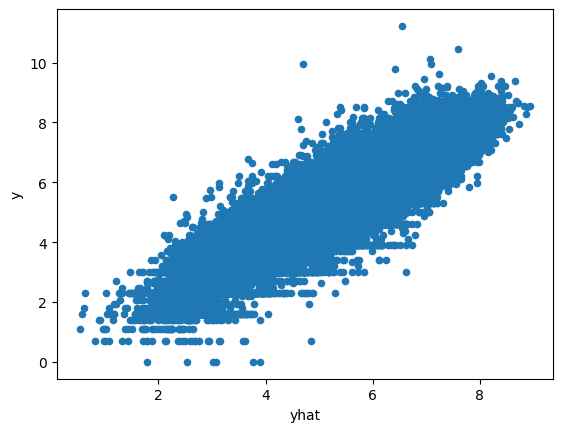

In [190]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':yhat})
df.plot.scatter(x='yhat',y='y')
df

That&rsquo;s all there is to estimation!  Note that we didn&rsquo;t estimate
demands for all goods&#x2014;lots of goods didn&rsquo;t have enough observations,
and were automatically dropped.



#### Parameters



##### (Relative) Income Elasticity



Here we use a plot to visualize *Frisch elasticities*, with confidence intervals. Higher values means that the good is more elastic in response to changes in income.


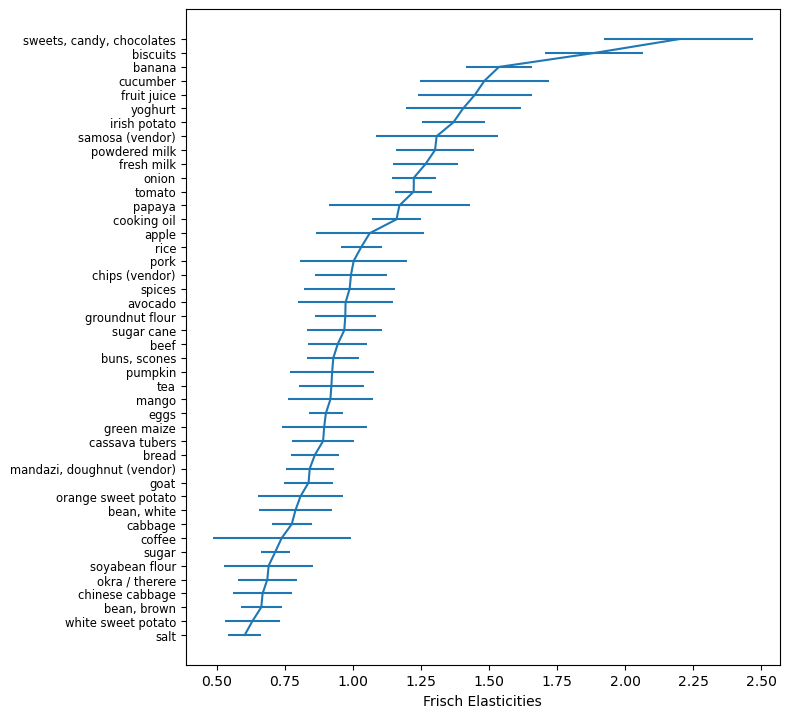

In [195]:
ax = result.graph_beta()

To just see the values of $\beta$:



In [196]:
result.get_beta()

j
apple                         1.061399
avocado                       0.972590
banana                        1.536151
bean, brown                   0.662865
bean, white                   0.788431
beef                          0.943798
biscuits                      1.884134
bread                         0.859897
buns, scones                  0.927580
cabbage                       0.774838
cassava tubers                0.890022
chinese cabbage               0.667778
chips (vendor)                0.992481
coffee                        0.737935
cooking oil                   1.159792
cucumber                      1.482824
eggs                          0.900173
fresh milk                    1.266606
fruit juice                   1.448093
goat                          0.836689
green maize                   0.893959
groundnut flour               0.971502
irish potato                  1.368730
mandazi, doughnut (vendor)    0.840786
mango                         0.916784
okra / therere         

##### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [197]:
result.get_gamma()

k,boys,women,girls,men,M 00-03,F 00-03,M 04-08,F 04-08,M 09-13,F 09-13,M 14-18,F 14-18,M 19-30,F 19-30,M 31-50,F 31-50,M 51+,F 51+,log HSize,Constant
j,,,,,,,,,,,,,,,,,,,,
apple,-0.031720,0.076535,-0.017094,0.053651,-0.065640,-0.104843,0.026905,-0.087370,0.042676,0.076436,-0.163504,-0.131782,-0.216515,0.005600,0.115411,0.310417,0.282597,-0.009016,0.016513,5.932196
avocado,0.086286,-0.066432,0.107439,-0.028767,-0.285528,-0.223430,-0.238284,-0.189535,-0.008503,-0.053335,-0.074284,-0.177535,-0.082614,0.170708,0.272829,0.473440,0.473903,0.040694,0.120301,4.953361
banana,0.003384,-0.000315,-0.019295,0.004525,-0.333613,-0.290454,-0.213212,-0.193651,-0.073031,-0.127110,-0.074397,-0.047139,-0.154844,0.138946,0.350208,0.403384,0.506797,0.096413,0.104519,5.246872
"bean, brown",-0.047984,-0.003926,0.016204,0.046118,-0.124959,-0.207804,-0.046063,-0.174234,0.076636,-0.039408,0.000439,0.003630,-0.168268,0.023059,0.050372,0.265363,0.209978,0.141672,0.236086,5.838157
"bean, white",0.102343,0.082910,-0.069753,-0.073166,-0.331555,-0.138113,-0.201383,0.103093,0.056346,0.097682,0.060263,0.056387,0.008220,-0.092352,0.261993,-0.030759,0.175293,0.017219,-0.001874,5.537910
beef,0.054363,0.065431,-0.089510,-0.124046,-0.285134,-0.175888,-0.189804,-0.085961,-0.139460,-0.033343,-0.096264,-0.026278,0.001654,-0.057108,0.296555,0.222811,0.342770,0.131689,0.303220,7.011164
biscuits,-0.153701,-0.047347,0.041043,-0.016432,-0.389171,-0.438982,-0.094395,-0.317928,0.133612,-0.114724,-0.008462,-0.102731,-0.189674,0.159492,0.274614,0.511474,0.103343,0.297095,0.096371,5.360265
bread,-0.024013,-0.042757,0.020553,-0.027265,-0.227797,-0.233592,-0.110751,-0.164646,-0.049587,-0.097004,-0.062306,-0.046563,-0.045914,0.070723,0.210965,0.286501,0.234112,0.162378,0.390364,6.368836
"buns, scones",-0.051593,-0.022729,0.001793,0.034461,-0.216007,-0.197579,-0.037939,-0.169118,0.077554,-0.081193,-0.056679,0.000214,-0.189524,0.074242,0.172441,0.247089,0.233023,0.105408,0.314469,5.393057


##### Welfare



Another import quantity we estimate is $w_i$.  This is a welfare measure for the household.  Here&rsquo;s a histogram:



<Axes: ylabel='Density'>

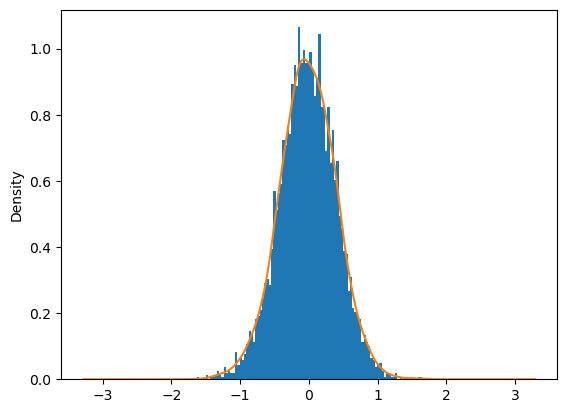

In [198]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

#### Saving Result



You can save the estimated result, using something like



In [199]:
# Save the regression result
result.to_pickle('malawi_estimates.rgsn')

You can subsequently load this using



In [200]:

result = cfe.regression.read_pickle('malawi_estimates.rgsn')

#### Demand and Utility



Having estimated the demand system, we can examine the implied demand curves.



##### Budgets



Get food budget for all households, then find median budget:



In [201]:


# Get predicted expenditures
xhat = result.predicted_expenditures()

# Total food expenditures per household (i, t, m)
xbar = xhat.groupby(['i', 't', 'm']).sum()

# Reference budget: median household's budget
xref = xbar.quantile(0.5)  # 50th percentile

##### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [202]:
p = p_0405

In [203]:
# Step 1: Average prices across markets
pbar = p.mean(axis=1)  # average over markets (axis=1)

# Step 2: Keep only goods that exist in both price data and estimated betas
estimated_goods = result.beta.index             # goods estimated by the model
available_goods = pbar.index                    # goods for which we have price data
common_goods = estimated_goods.intersection(available_goods)  # safe intersection
pbar = pbar.loc[common_goods]

# Step 3: Replace any missing values with 1 (for stability in simulations)
pbar = pbar.replace(np.nan, 1)

def my_prices(p0, j, p=pbar):
    """
    Change price of j-th good to p0, holding other prices fixed.
    
    Parameters:
    p0: new price to set
    j:  name of the good (string)
    p:  reference price vector (default: pbar)
    """
    p = p.copy()
    p.loc[j] = p0
    return p

##### Demand as a function of prices



Let&rsquo;s take a look at demand schedules for households with different budgets.



In [204]:
pbar.head()

Series([], dtype: float64)

In [205]:
import matplotlib.pyplot as plt


#Step 1: Get average price per good from the data
pbar_full = p.mean(axis=1)  # Average across markets

#Step 2: Reindex to match the order of goods used in the regression model
goods = result.beta.index  # This is the correct good order expected by the model
pbar = pbar_full.reindex(goods)  # Align price vector to match model order

#Step 3: Fill any missing prices with 1 (to avoid errors)
pbar = pbar.fillna(1)

#Step 4: Choose a good from the list (make sure it's in result.beta.index)
print("Available goods:", list(pbar.index))
use = 'maize ufa mgaiwa (normal f'  # Replace with another valid good if needed

#Step 5: Define a safe price-change function
def my_prices(p0, j, p=pbar):
    p = p.copy()
    p.loc[j] = p0
    return p

#Step 6: Plot demand curve
scale = np.linspace(0.5, 2, 20)

#Demand at median budget
plt.plot(
    [result.demands(xref, my_prices(pbar[use] * s, use))[use] for s in scale],
    scale,
    label='Median HH'
)

#25th percentile budget
plt.plot(
    [result.demands(xbar.quantile(0.25), my_prices(pbar[use] * s, use))[use] for s in scale],
    scale,
    label='25th %ile HH'
)

#75th percentile budget
plt.plot(
    [result.demands(xbar.quantile(0.75), my_prices(pbar[use] * s, use))[use] for s in scale],
    scale,
    label='75th %ile HH'
)

#Step 7: Final plot formatting
plt.xlabel(f"Quantities of {use} Demanded")
plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.title(f"Demand Curve for {use}")
plt.legend()
plt.grid(True)
plt.show()

Available goods: ['apple', 'avocado', 'banana', 'bean, brown', 'bean, white', 'beef', 'biscuits', 'bread', 'buns, scones', 'cabbage', 'cassava tubers', 'chinese cabbage', 'chips (vendor)', 'coffee', 'cooking oil', 'cucumber', 'eggs', 'fresh milk', 'fruit juice', 'goat', 'green maize', 'groundnut flour', 'irish potato', 'mandazi, doughnut (vendor)', 'mango', 'okra / therere', 'onion', 'orange sweet potato', 'papaya', 'pork', 'powdered milk', 'pumpkin', 'rice', 'salt', 'samosa (vendor)', 'soyabean flour', 'spices', 'sugar', 'sugar cane', 'sweets, candy, chocolates', 'tea', 'tomato', 'white sweet potato', 'yoghurt']


KeyError: 'maize ufa mgaiwa (normal f'

##### Engel Curves



Engel curves trace out how demand changes with budget:



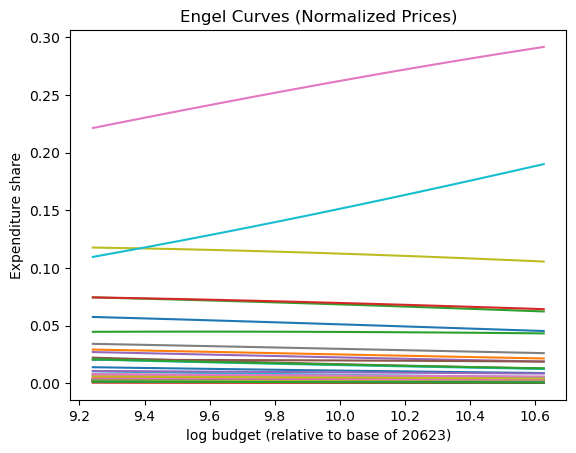

In [206]:
# Step 1: Normalize reference prices so their average is 1
pbar_normalized = pbar / pbar.mean()

# Step 2: Recalculate Engel curves with normalized pbar
fig, ax = plt.subplots()

ax.plot(
    np.log(scale * xref),
    [result.expenditures(s * xref, pbar_normalized) / (s * xref) for s in scale]
)

ax.set_xlabel(f"log budget (relative to base of {xref:.0f})")
ax.set_ylabel("Expenditure share")
ax.set_title("Engel Curves (Normalized Prices)")

plt.show()

In [207]:
# Expenditure shares at base budget
shares = result.expenditures(xref, pbar) / xref
shares.sort_values(ascending=False).head(10)

j
biscuits                     0.258761
sweets, candy, chocolates    0.147360
fruit juice                  0.112997
yoghurt                      0.070099
irish potato                 0.068962
powdered milk                0.051655
banana                       0.044551
fresh milk                   0.030215
tomato                       0.025332
cooking oil                  0.022798
Name: quantities, dtype: float64

Engel Curve of Top 5 Non-Dominant Goods (exclude Huile de soja / végétale):

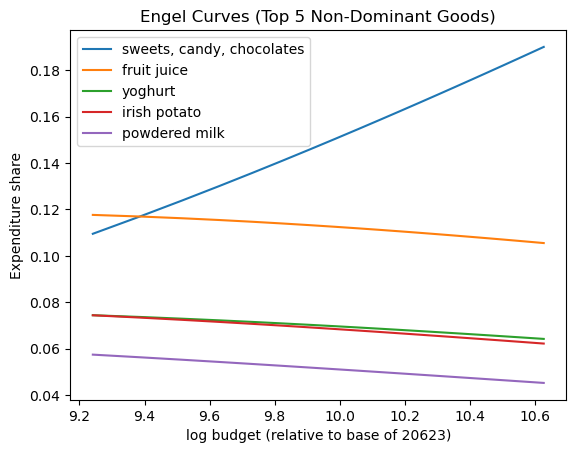

In [208]:
import consumerdemands._core as core

# Loosen solver tolerance to avoid convergence issues
core.default_solver_tolerance = 1e-8

# Step 1: Define scale
scale = np.linspace(0.5, 2, 20)

# Step 2: Calculate expenditure shares
shares = result.expenditures(xref, pbar) / xref
dominant_good = shares.sort_values(ascending=False).index[0]
top_goods = shares.drop(dominant_good).sort_values(ascending=False).head(5).index

# Step 3: Compute Engel curves using full price vector
fig, ax = plt.subplots()

for g in top_goods:
    share_curve = []
    for s in scale:
        try:
            demands = result.demands(s * xref, pbar)
            share = demands[g] * pbar[g] / (s * xref)
            share_curve.append(share)
        except Exception as e:
            print(f"Skipped {g} at scale {s} due to error: {e}")
            share_curve.append(np.nan)
    
    ax.plot(np.log(scale * xref), share_curve, label=g)

# Step 4: Plot formatting
ax.set_xlabel(f"log budget (relative to base of {xref:.0f})")
ax.set_ylabel("Expenditure share")
ax.set_title("Engel Curves (Top 5 Non-Dominant Goods)")
ax.legend()
plt.show()

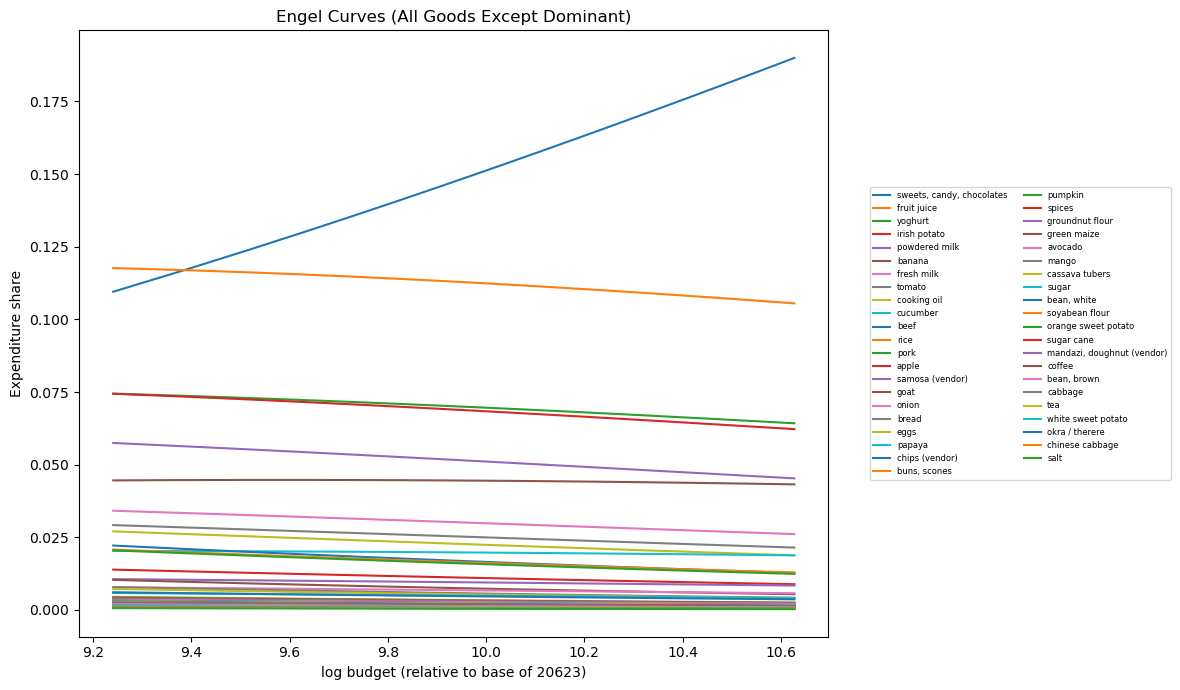

In [209]:
# Step 1: Compute expenditure shares at base budget
shares = result.expenditures(xref, pbar) / xref

# Step 2: Drop dominant good (the one with the highest share)
shares_no_dominant = shares.sort_values(ascending=False).iloc[1:]
goods_to_plot = shares_no_dominant.index

# Step 3: Budget scaling range
scale = np.linspace(0.5, 2, 20)

# Step 4: Plot Engel curves
fig, ax = plt.subplots(figsize=(12, 7))

for g in goods_to_plot:
    share_curve = [
        result.demands(s * xref, pbar)[g] * pbar[g] / (s * xref)
        for s in scale
    ]
    ax.plot(np.log(scale * xref), share_curve, label=g)

# Step 5: Labels, legend, formatting
ax.set_xlabel(f"log budget (relative to base of {xref:.0f})")
ax.set_ylabel("Expenditure share")
ax.set_title("Engel Curves (All Goods Except Dominant)")
ax.legend(fontsize=6, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=2)
plt.tight_layout()
plt.show()

##### Indirect Utility



We can also describe an indirect utility function that corresponds to these demands:



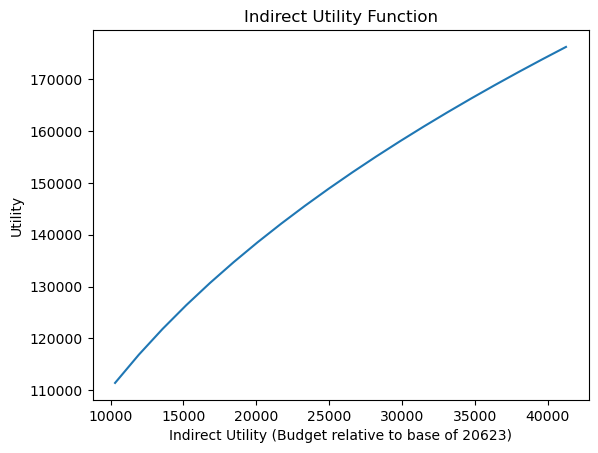

In [210]:
# Plot the indirect utility function over scaled budgets
fig, ax = plt.subplots()

# Compute utility values for different scaled budgets
utilities = [result.indirect_utility(s * xref, pbar) for s in scale]

# Plot
ax.plot(scale * xref, utilities)
ax.set_xlabel(f"Indirect Utility (Budget relative to base of {xref:.0f})")
ax.set_ylabel("Utility")
ax.set_title("Indirect Utility Function")
plt.show()

# Nutritional Analysis of Diet

In [164]:
fct = pd.read_csv("./Data/FCT.csv", index_col = 0)
fct.head()

,k,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
j,,,,,,,,,,,,,,,,
Avocado,Avocat,1600,20.0,70.0,810,120,85.0,6.0,17.38,1.30,0.67,70,0.0,2.57,100,6.0
Beans (dry),Haricots (secs),1700,98.0,60.0,500,580,325.0,30.0,7.00,1.20,3.40,0,0.0,2.15,10,8.0
Beans (fresh),Haricots (frais),3470,214.0,160.0,5250,1130,626.0,51.0,11.74,2.12,7.13,0,0.0,4.74,63,23.0
Beef,Bœuf,2510,182.0,0.0,60,70,0.0,19.0,31.50,1.60,0.90,0,28.9,3.80,0,37.0
Beef (roasted),Bœuf (rôti),2910,264.0,0.0,70,90,0.0,27.0,37.20,2.20,0.90,0,24.7,3.40,0,60.0


In [211]:

# Get expenditures...
expend = pd.concat([expenditures_0405, expenditures_1011, expenditures_1617, expenditures_1920])
expend.fillna(0)

,,j,apple,avocado,banana,"bean, brown","bean, white",beef,biscuits,bottled/ canned beer,bread,breakfast cereal,...,Maize ufa processed madeya (bran flour - processed),Maize ufa raw madeya (bran flour - unprocessed),"Other poultry - guinea fowl, doves, etc",Pigeon pea (nandolo),Roasted groundnuts,Roasted sweet potatoes,"Small animal – rabbit, mice, etc","Soft drinks (coca-cola, fanta, sprite, etc)","Wild fruit (masau, malambe, etc)",Zikondamoyo / nkate
i,t,m,,,,,,,,,,,,,,,,,,,,,
10101002025,2004-05,North,0.0,10.0,0.0,0.0,0.0,160.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10101002051,2004-05,North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10101002072,2004-05,North,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10101002079,2004-05,North,0.0,16.0,60.0,0.0,0.0,60.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10101002095,2004-05,North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315538160177,2019-20,Southern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
315538160189,2019-20,Southern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
315538160190,2019-20,Southern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [212]:


result.get_beta().sort_values(ascending=False) # Check sanity...

j
sweets, candy, chocolates     2.196028
biscuits                      1.884134
banana                        1.536151
cucumber                      1.482824
fruit juice                   1.448093
yoghurt                       1.404330
irish potato                  1.368730
samosa (vendor)               1.307202
powdered milk                 1.301273
fresh milk                    1.266606
onion                         1.223402
tomato                        1.222903
papaya                        1.170417
cooking oil                   1.159792
apple                         1.061399
rice                          1.030236
pork                          1.002448
chips (vendor)                0.992481
spices                        0.987706
avocado                       0.972590
groundnut flour               0.971502
sugar cane                    0.967875
beef                          0.943798
buns, scones                  0.927580
pumpkin                       0.923286
tea                    

# Top 10 most consumed foods


In [213]:
import plotly.express as px
import matplotlib.pyplot as plt


def plot_top_foods_by_household(
    hhc,
    expend,
    min_males=0, max_males=None,
    min_females=0, max_females=None,
    min_kids=0, max_kids=None,
    top_n=10
):
    """Filters households by demographic range and plots top consumed foods by expenditure."""

    # Set multi-index if not already
    hhc.index.names = ['i', 't', 'm']
    expend.index.names = ['i', 't', 'm']
    hhc.index.names = ['i', 't', 'm']
    male_adult_cols   = ["M 19-30", "M 31-50", "M 51+"]
    female_adult_cols = ["F 19-30", "F 31-50", "F 51+"]
    kid_cols          = [
            "F 00-03", "M 00-03",
            "F 04-08", "M 04-08",
            "F 09-13", "M 09-13",
            "F 14-18", "M 14-18"
        ]
    

    # 2) Compute “total men,” “total women,” “total kids” per row
    #    (copy so we don't alter the original DataFrame)
    hhc = hhc.copy()
    hhc["male_adults"]   = hhc[male_adult_cols].sum(axis=1)
    hhc["female_adults"] = hhc[female_adult_cols].sum(axis=1)
    hhc["kids"]          = hhc[kid_cols].sum(axis=1)
    
    # 3) Build a Boolean mask based on the input constraints
    mask = True

    # male adults
    if max_males is None:
        mask &= (hhc["male_adults"] >= min_males)
    else:
        mask &= (hhc["male_adults"] >= min_males) & (hhc["male_adults"] <= max_males)
    
    # female adults
    if max_females is None:
        mask &= (hhc["female_adults"] >= min_females)
    else:
        mask &= (hhc["female_adults"] >= min_females) & (hhc["female_adults"] <= max_females)
    
    # kids
    if max_kids is None:
        mask &= (hhc["kids"] >= min_kids)
    else:
        mask &= (hhc["kids"] >= min_kids) & (hhc["kids"] <= max_kids)

    # 4) Filter the household composition
    hhc_filtered = hhc[mask]
    #common_idx = hhc_filtered.index.intersection(expend.index)
    #expend_filtered = expend.loc[common_idx]

    # Sum expenditures per food
    #top_expenditures = expend_filtered.sum().sort_values(ascending=False).head(top_n)
    top_expenditures = expend.sum().sort_values(ascending=False).head(top_n)
    # Plot
    plt.figure(figsize=(10, 6))
    top_expenditures.sort_values().plot(kind='barh')
    plt.title(f"Top {top_n} Food Items by Expenditure for Selected Household Type")
    plt.xlabel("Total Expenditure")
    plt.tight_layout()
    plt.show()

    return top_expenditures



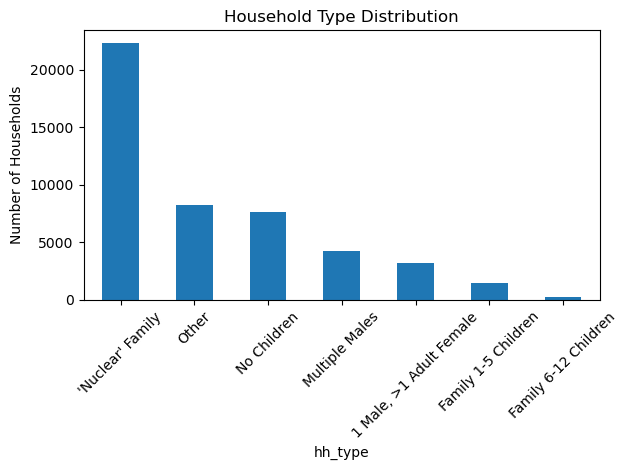

In [214]:

    
    # 2) Compute “total men,” “total women,” “total kids” per row
    #    (copy so we don't alter the original DataFrame)
hhc1 = hhc.copy()

def classify_household(row):
    if row["men"] == 1 and row["women"] == 1 and row["girls"]+row['boys'] > 0:
        return "'Nuclear' Family"
    elif row["men"] == 1 and row["women"] > 1 and row["girls"]+row['boys'] > 0:
        return "1 Male, >1 Adult Female"
    elif row["men"] > 1 and row["women"] <= 1 and row["girls"]+row['boys'] > 0:
        return "Multiple Males"
    elif row["men"] > 1 and row["women"] >1 and row["girls"]+row['boys'] > 1 and row["girls"]+row['boys'] <= 5:
        return "Family 1-5 Children"
    elif row["men"] > 1 and row["women"] >1 and row["girls"]+row['boys'] > 5 and row["girls"]+row['boys'] <= 12:
        return "Family 6-12 Children"
    elif row["men"] >= 0 and row["women"] >= 0 and row["girls"]+row['boys'] == 0:
        return "No Children"
    else:
        return "Other"
hhc["hh_type"] = hhc.apply(classify_household, axis=1)
# Plot household type distribution
import matplotlib.pyplot as plt
hhc["hh_type"].value_counts().plot(kind="bar", title="Household Type Distribution")
plt.ylabel("Number of Households")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [215]:
hhc = hhc.set_index(["i", "t", "m"])
hhc.index.names = ["i", "t", "m"]
hhc

,,,boys,women,girls,men,M 00-03,F 00-03,M 04-08,F 04-08,M 09-13,F 09-13,M 14-18,F 14-18,M 19-30,F 19-30,M 31-50,F 31-50,M 51+,F 51+,log HSize,hh_type
i,t,m,,,,,,,,,,,,,,,,,,,,
10101002025,2004-05,North,3,1,2,1,1,1,0,1,1,0,1,0,0,0,1,1,0,0,1.945910,'Nuclear' Family
10101002051,2004-05,North,0,1,1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1.098612,'Nuclear' Family
10101002072,2004-05,North,3,1,1,1,1,1,1,0,0,0,1,0,0,1,1,0,0,0,1.791759,'Nuclear' Family
10101002079,2004-05,North,1,1,3,1,0,2,1,1,0,0,0,0,0,0,1,1,0,0,1.791759,'Nuclear' Family
10101002095,2004-05,North,2,1,2,1,0,0,0,2,2,0,0,0,1,1,0,0,0,0,1.791759,'Nuclear' Family
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315538160177,2019-20,Southern,1,1,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1.098612,'Nuclear' Family
315538160189,2019-20,Southern,0,1,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1.098612,'Nuclear' Family
315538160190,2019-20,Southern,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.000000,No Children


In [216]:
nutrient_ratio = pd.concat([nutritional_ratio_0405, nutritional_ratio_1011, nutritional_ratio_1617, nutritional_ratio_1920])
nutrient_ratio.index.names = ["i","t","m"]
nutrient_ratio

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
10101002246,2004-05,North,0.317226,0.344176,0.122321,0.210407,0.054597,0.276591,0.165516,0.177329,0.367091,0.159299,0.106872,0.737308,0.288041,0.069373,0.195434
10101003013,2004-05,North,0.213677,0.265355,0.081655,0.143809,0.030084,0.181100,0.119858,0.124251,0.261348,0.112752,0.075495,0.550083,0.208752,0.052833,0.131278
10101003017,2004-05,North,0.693621,0.829830,0.170831,0.331070,0.071831,0.351300,0.298986,0.350356,0.681877,0.302770,0.199624,1.774968,0.610397,0.124745,0.369032
10101003020,2004-05,North,1.092045,0.965945,0.301179,0.524460,0.162772,0.758622,0.470854,0.507525,0.998185,0.456314,0.284456,2.246979,0.825002,0.155388,0.520011
10101003062,2004-05,North,0.325022,0.368357,0.100165,0.177115,0.037760,0.227791,0.142395,0.156775,0.349439,0.142809,0.105809,0.784125,0.292547,0.068301,0.162569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31202086188,2004-05,Southern,0.324609,0.631772,0.145691,0.302836,0.079226,0.305363,0.239356,0.287618,0.588813,0.274685,0.174388,1.312099,0.478938,0.095875,0.275925
31202086288,2004-05,Southern,0.568176,1.061634,0.244799,0.505301,0.128863,0.502401,0.450112,0.504819,0.991321,0.480468,0.281102,2.280970,0.822415,0.157709,0.460110
31202086289,2004-05,Southern,0.518419,0.863177,0.225420,0.448928,0.151655,0.594143,0.411470,0.448089,0.877739,0.427898,0.251213,1.967660,0.710626,0.122589,0.410203


In [231]:
def filter_households(
    hhc,              # The household composition DataFrame (indexed by i,t,m)
    nutrient_ratio,   # The nutrient outcomes DataFrame (indexed by i,t,m)
    xhat,
    min_males=0, max_males=None,
    min_females=0, max_females=None,
    min_kids=0, max_kids=None
):
    """
    Return the rows (households) whose composition fits the given
    # of adult males, adult females, and children,
    along with their corresponding nutrient outcomes.
    Both DataFrames must be MultiIndexed by (i, t, m).
    """

    # 1) Identify which columns correspond to kids vs adult males/females
    male_adult_cols   = ["M 19-30", "M 31-50", "M 51+"]
    female_adult_cols = ["F 19-30", "F 31-50", "F 51+"]
    kid_cols          = [
        "F 00-03", "M 00-03",
        "F 04-08", "M 04-08",
        "F 09-13", "M 09-13",
        "F 14-18", "M 14-18"
    ]
    
    # 2) Compute “total men,” “total women,” “total kids” per row
    #    (copy so we don't alter the original DataFrame)
    hhc = hhc.copy()
    hhc["male_adults"]   = hhc[male_adult_cols].sum(axis=1)
    hhc["female_adults"] = hhc[female_adult_cols].sum(axis=1)
    hhc["kids"]          = hhc[kid_cols].sum(axis=1)

    # 3) Build a Boolean mask based on the input constraints
    mask = True

    # male adults
    if max_males is None:
        mask &= (hhc["male_adults"] >= min_males)
    else:
        mask &= (hhc["male_adults"] >= min_males) & (hhc["male_adults"] <= max_males)
    
    # female adults
    if max_females is None:
        mask &= (hhc["female_adults"] >= min_females)
    else:
        mask &= (hhc["female_adults"] >= min_females) & (hhc["female_adults"] <= max_females)
    
    # kids
    if max_kids is None:
        mask &= (hhc["kids"] >= min_kids)
    else:
        mask &= (hhc["kids"] >= min_kids) & (hhc["kids"] <= max_kids)

    # 4) Filter the household composition
    hhc_filtered = hhc[mask]
   
    
    # 5) Intersection with nutrient_ratio's index
    #    so we only keep households that exist in BOTH data frames.
    common_idx = hhc_filtered.index.intersection(nutrient_ratio.index)
    hhc_filtered = hhc_filtered.loc[common_idx]
    nutrient_filtered = nutrient_ratio.loc[common_idx]

    # also filter out expenditures
    com_idx = hhc_filtered.index.intersection(xhat.unstack('j').index)
    house_expend = xhat.unstack('j')
    house_expend = house_expend.loc[com_idx]
    house_expend['total expenditures'] = house_expend[:].sum(axis=1)
    expenditures_filtered = house_expend
   
    return hhc_filtered, nutrient_filtered, expenditures_filtered


# Ensure both DataFrames are set to (i, t, m) as their index
hhc.index.names = ["i","t","m"]
nutrient_ratio = pd.concat([nutritional_ratio_0405, nutritional_ratio_1011, nutritional_ratio_1617, nutritional_ratio_1920])
nutrient_ratio.index.names = ["i","t","m"]


In [233]:
nutritional_ratio_1011

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,


In [218]:
hhc_filtered, nutr_filt, expenditures_filtered = filter_households(
    hhc,              # The household composition DataFrame (indexed by i,t,m)
    nutrient_ratio,   # The nutrient outcomes DataFrame (indexed by i,t,m)
    xhat,
    min_males=0, max_males=100,
    min_females=0, max_females=100,
    min_kids=0, max_kids=100
)

hhc_filtered



,,,boys,women,girls,men,M 00-03,F 00-03,M 04-08,F 04-08,M 09-13,F 09-13,...,F 19-30,M 31-50,F 31-50,M 51+,F 51+,log HSize,hh_type,male_adults,female_adults,kids
i,t,m,,,,,,,,,,,,,,,,,,,,,
10101002246,2004-05,North,1,1,0,1,1,0,0,0,0,0,...,1,1,0,0,0,1.098612,'Nuclear' Family,1,1,1
10101003013,2004-05,North,0,1,4,1,0,1,0,1,0,2,...,1,1,0,0,0,1.791759,'Nuclear' Family,1,1,4
10101003017,2004-05,North,1,1,4,1,0,2,0,1,1,1,...,0,1,1,0,0,1.945910,'Nuclear' Family,1,1,5
10101003020,2004-05,North,0,1,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0.693147,No Children,1,1,0
10101003062,2004-05,North,2,1,5,2,0,2,0,2,1,0,...,0,1,1,0,0,2.302585,Multiple Males,1,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31202086188,2004-05,Southern,0,1,2,1,0,1,0,1,0,0,...,1,0,0,0,0,1.386294,'Nuclear' Family,1,1,2
31202086288,2004-05,Southern,2,1,0,1,0,0,1,0,1,0,...,1,1,0,0,0,1.386294,'Nuclear' Family,1,1,2
31202086289,2004-05,Southern,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0.693147,No Children,1,1,0


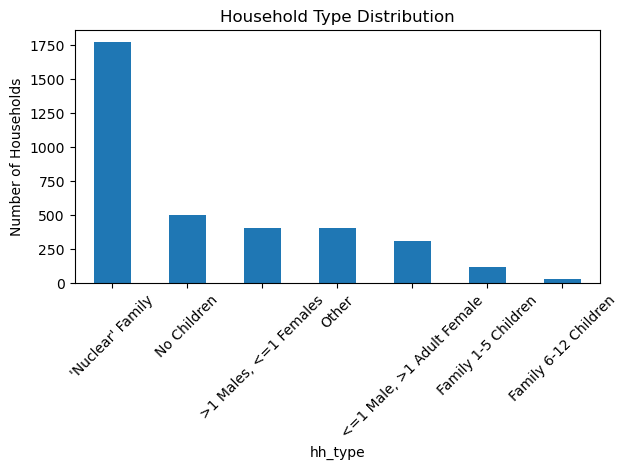

In [219]:

def classify_household(row):
    if row["male_adults"] == 1 and row["female_adults"] == 1 and row["kids"] > 0:
        return "'Nuclear' Family"
    elif row["male_adults"] <= 1 and row["female_adults"] > 1 and row["kids"] > 0 and row["kids"] <12:
        return "<=1 Male, >1 Adult Female"
    elif row["male_adults"] > 1 and row["female_adults"] <= 1 and row["kids"] > 0:
        return ">1 Males, <=1 Females"
    elif row["male_adults"] > 1 and row["female_adults"] >1 and row["kids"] > 1 and row["kids"] <= 5:
        return "Family 1-5 Children"
    elif row["male_adults"] > 1 and row["female_adults"] >1 and row["kids"] > 5 and row["kids"] <= 12:
        return "Family 6-12 Children"
    elif row["male_adults"] >= 0 and row["female_adults"] >= 0 and row["kids"] == 0:
        return "No Children"
    else:
        return "Other"
hhc_filtered["hh_type"] = hhc_filtered.apply(classify_household, axis=1)
# Plot household type distribution
import matplotlib.pyplot as plt
hhc_filtered["hh_type"].value_counts().plot(kind="bar", title="Household Type Distribution")
plt.ylabel("Number of Households")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [220]:
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
import seaborn as sns
import math

def analyze_nutritional_adequacy_subplots_log(
    nut_df,
    adequacy_threshold=1.0,  # We'll draw a vertical line at log10(1.0) = 0
    bins=30,
    n_cols=3
):
    """
    Create subplots of histograms for each nutrient ratio, using log10 scale.
    We drop any rows where a nutrient ratio <= 0 to avoid log(0) or log(negative).
    
    Parameters:
    -----------
    nut_df : pd.DataFrame
        DataFrame of nutrient adequacy ratios, with each column a nutrient.
    adequacy_threshold : float
        We'll add a vertical line at log10(adequacy_threshold).
        e.g. if threshold=1.0, the line is at x=0. 
    bins : int
        Number of histogram bins.
    n_cols : int
        Number of columns of subplots (we auto-calc rows).
    """

    # 1) Filter out rows where any ratio <= 0
    #    (log10 is undefined for non-positive values)
    mask = (nut_df > 0).all(axis=1)
    df_pos = nut_df[mask].copy()
    
    # 2) Decide which columns to plot (skip any columns like 'n' if needed)
    plot_cols = [c for c in df_pos.columns if c not in ["n"]]
    
    # 3) Compute log10 for each plotted nutrient
    for col in plot_cols:
        df_pos["log10_" + col] = np.log10(df_pos[col])

    # 4) Create subplots: N rows x n_cols
    n_rows = math.ceil(len(plot_cols) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 3*n_rows), sharey=False)
    axes = axes.flatten()

    log_threshold = np.log10(adequacy_threshold)

    # 5) For each nutrient column, plot histogram of log10(ratio)
    for i, col in enumerate(plot_cols):
        ax = axes[i]
        sns.histplot(df_pos["log10_" + col], bins=bins, kde=False, ax=ax)
        ax.axvline(log_threshold, color="red", linestyle="--")
        ax.set_title(f"{col} (log scale)")
        ax.set_xlabel("log10(Adequacy Ratio)")
        ax.set_ylabel("Count of Households")

    # Hide extra subplot axes if the # of nutrients isn't a multiple of n_cols
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

     # 3) Compute fraction that meet/exceed threshold
    fraction_meeting = {}
    for col in nut_df.columns:
        if col in ("n",):  # skip non‐ratio columns
            continue
        # fraction of households with ratio >= threshold
        fraction_meeting[col] = (nut_df[col] >= adequacy_threshold).mean()

    # Turn this into a DataFrame for easy plotting
    frac_df = pd.DataFrame.from_dict(fraction_meeting, orient="index", columns=["Fraction >= Threshold"])
    frac_df = frac_df.sort_values("Fraction >= Threshold", ascending=False)

    # Plot bar chart
    plt.figure(figsize=(7, 4))
    sns.barplot(x=frac_df["Fraction >= Threshold"], y=frac_df.index, orient="h")
    plt.title(f"Fraction of Households Meeting >= {adequacy_threshold} Ratio")
    plt.xlim(0, 1)  # fraction from 0 to 1
    for i, val in enumerate(frac_df["Fraction >= Threshold"]):
        plt.text(val + 0.01, i, f"{val:.1%}", va='center')  # label with percentage
    plt.tight_layout()
    plt.show()


# Household Characteristic - All Households, All Years

Average Weekly Food Expenditures: $3281.22 ($5.67 USD)


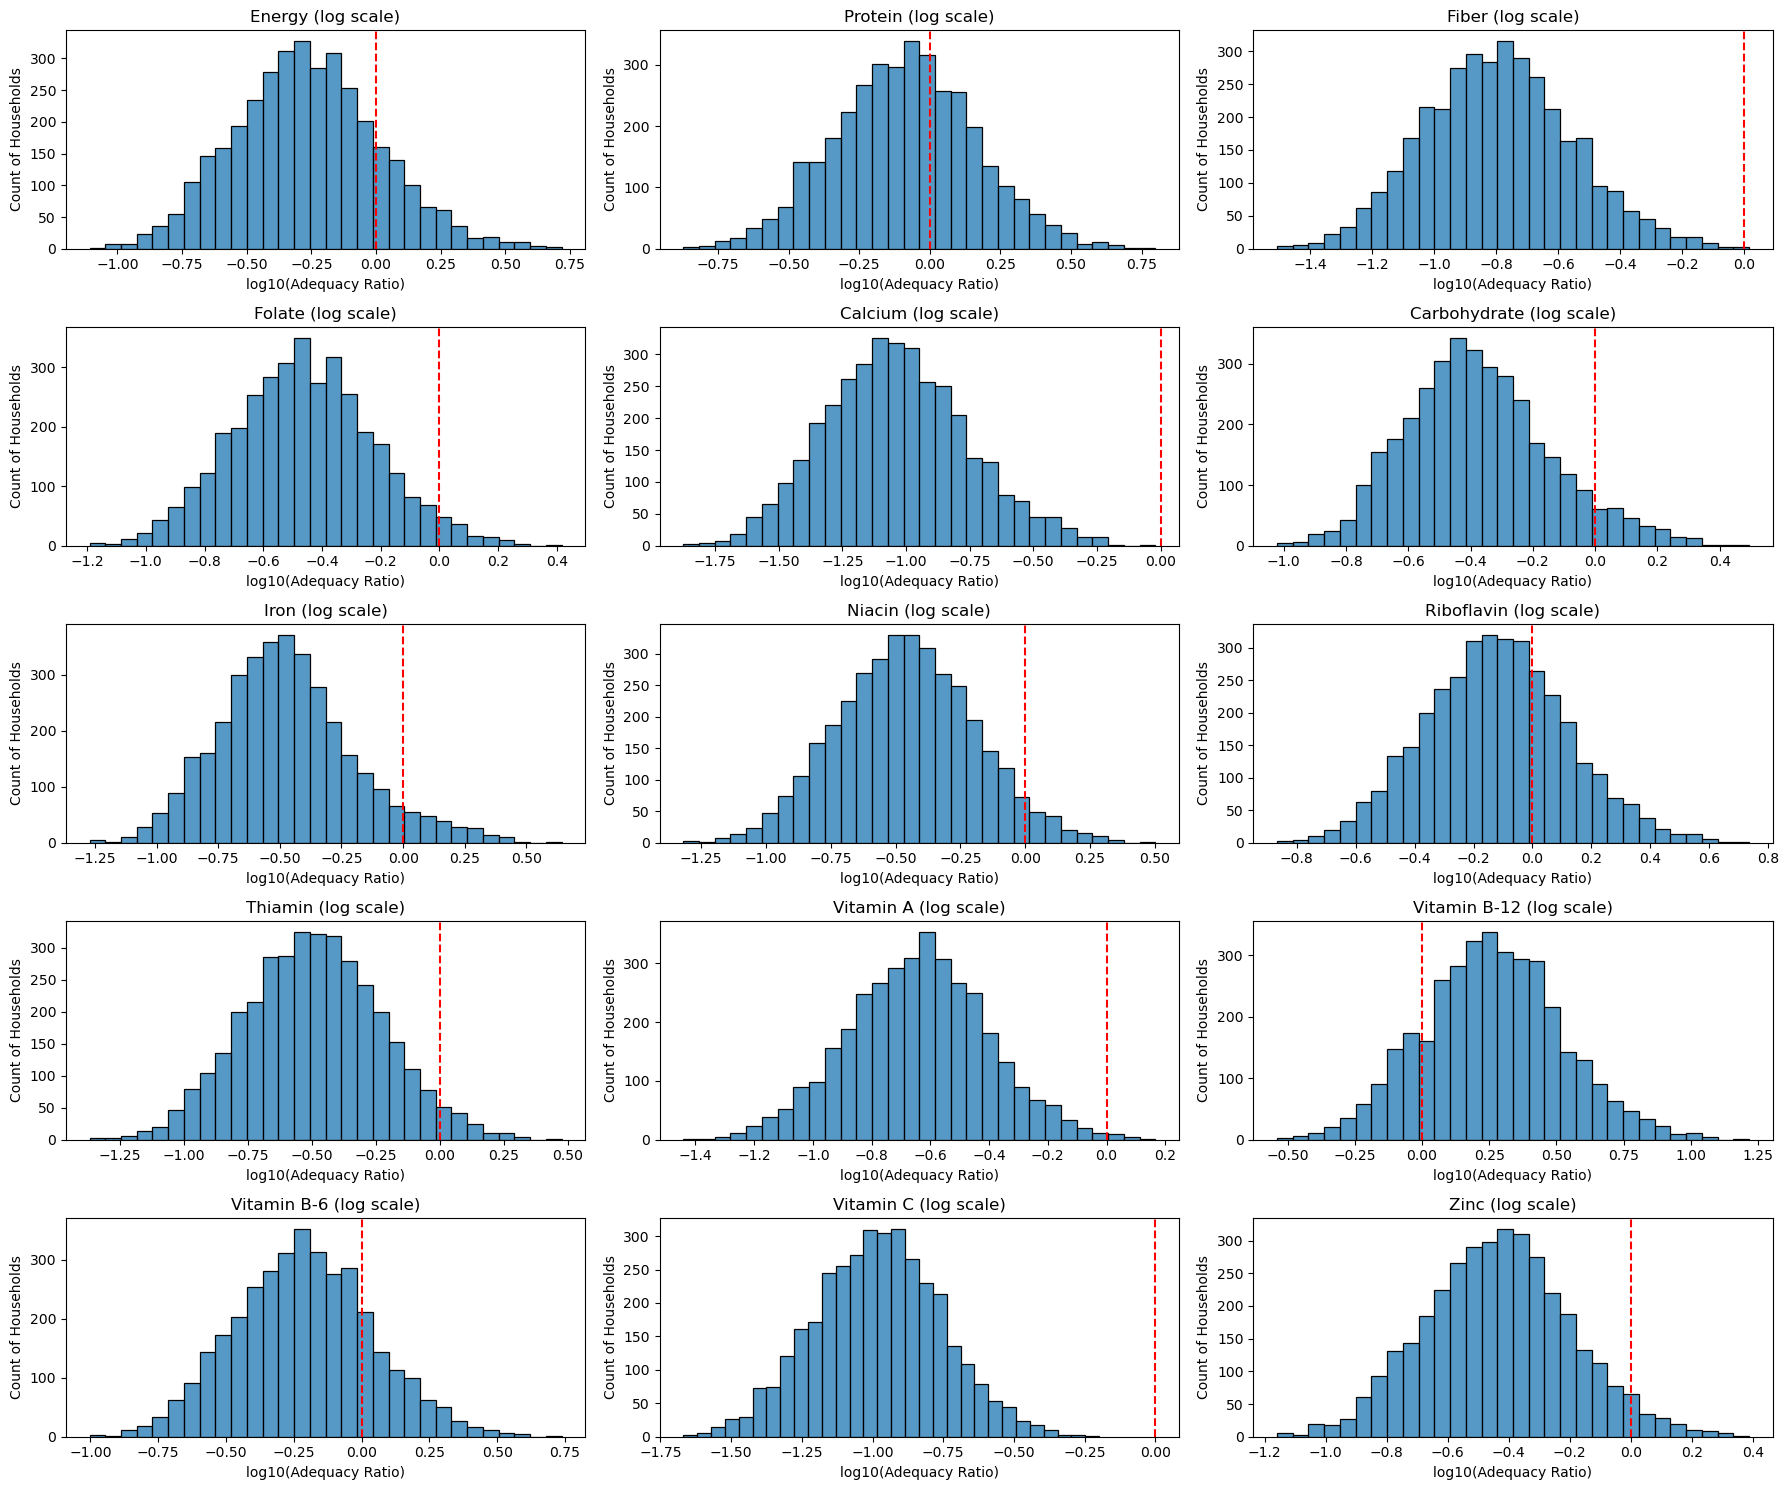

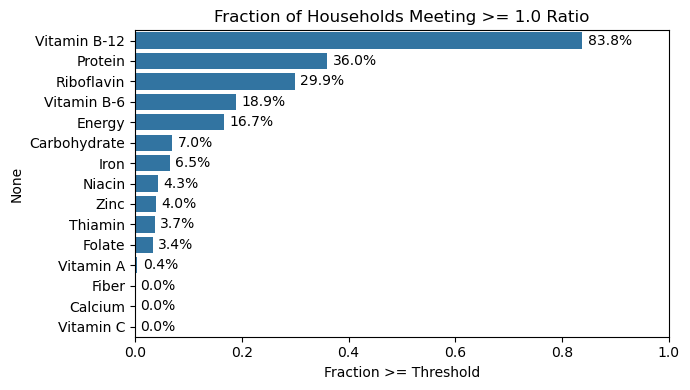

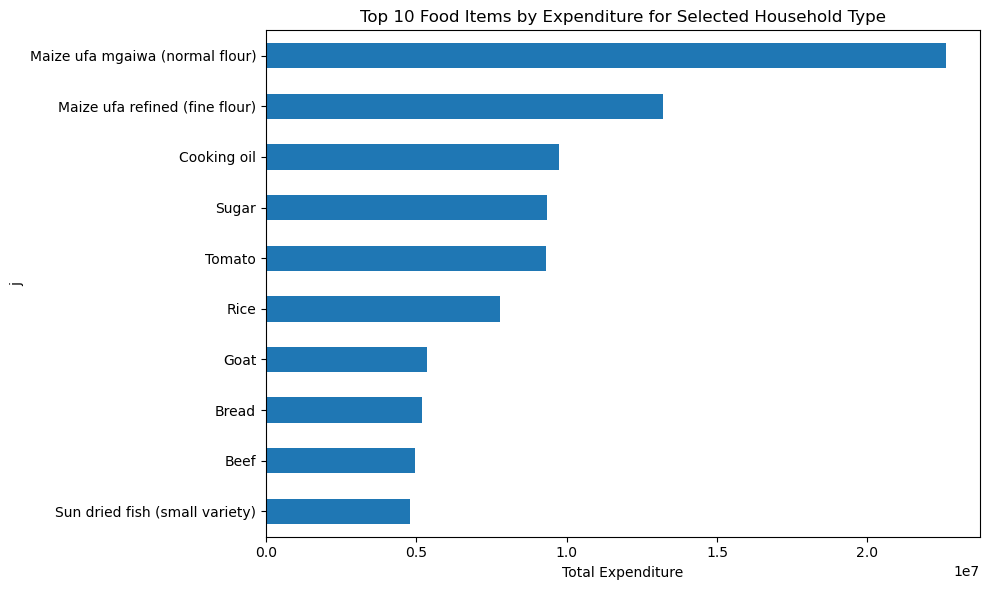

j
Maize ufa mgaiwa (normal flour)    22614580.0
Maize ufa refined (fine flour)     13213775.0
Cooking oil                         9755763.0
Sugar                               9331447.0
Tomato                              9306592.0
Rice                                7797477.0
Goat                                5357271.0
Bread                               5180935.0
Beef                                4957586.0
Sun dried fish (small variety)      4796095.0
dtype: float64

In [221]:
hhc_sub, nut_sub, expenditures_filtered = filter_households(
    hhc,
    nutrient_ratio,
    xhat,
    min_males=0, max_males=100,       # e.g. 0 adult males
    min_females=0, max_females=100,   # e.g. 1–3 adult females
    min_kids=0, max_kids=100        # e.g. up to 2 kids
)
avg_expend = expenditures_filtered['total expenditures'].mean().round(2)
avg_expend_usd = (0.0017279606*avg_expend).round(2)
print(f'Average Weekly Food Expenditures: ${avg_expend} (${avg_expend_usd} USD)')
analyze_nutritional_adequacy_subplots_log(nut_sub)
plot_top_foods_by_household(
    hhc,
    expend, 
    min_males=0, max_males=100,       # e.g. 0 adult males
    min_females=0, max_females=100,   # e.g. 1–3 adult females
    min_kids=0, max_kids=100)

In [222]:

print(f'# households:{hhc_sub.shape}')
#analyze_nutritional_adequacy(nut_sub)

# households:(3566, 23)


# households:(314, 23)
Average Weekly Food Expenditures: $3803.87 ($6.57 USD)


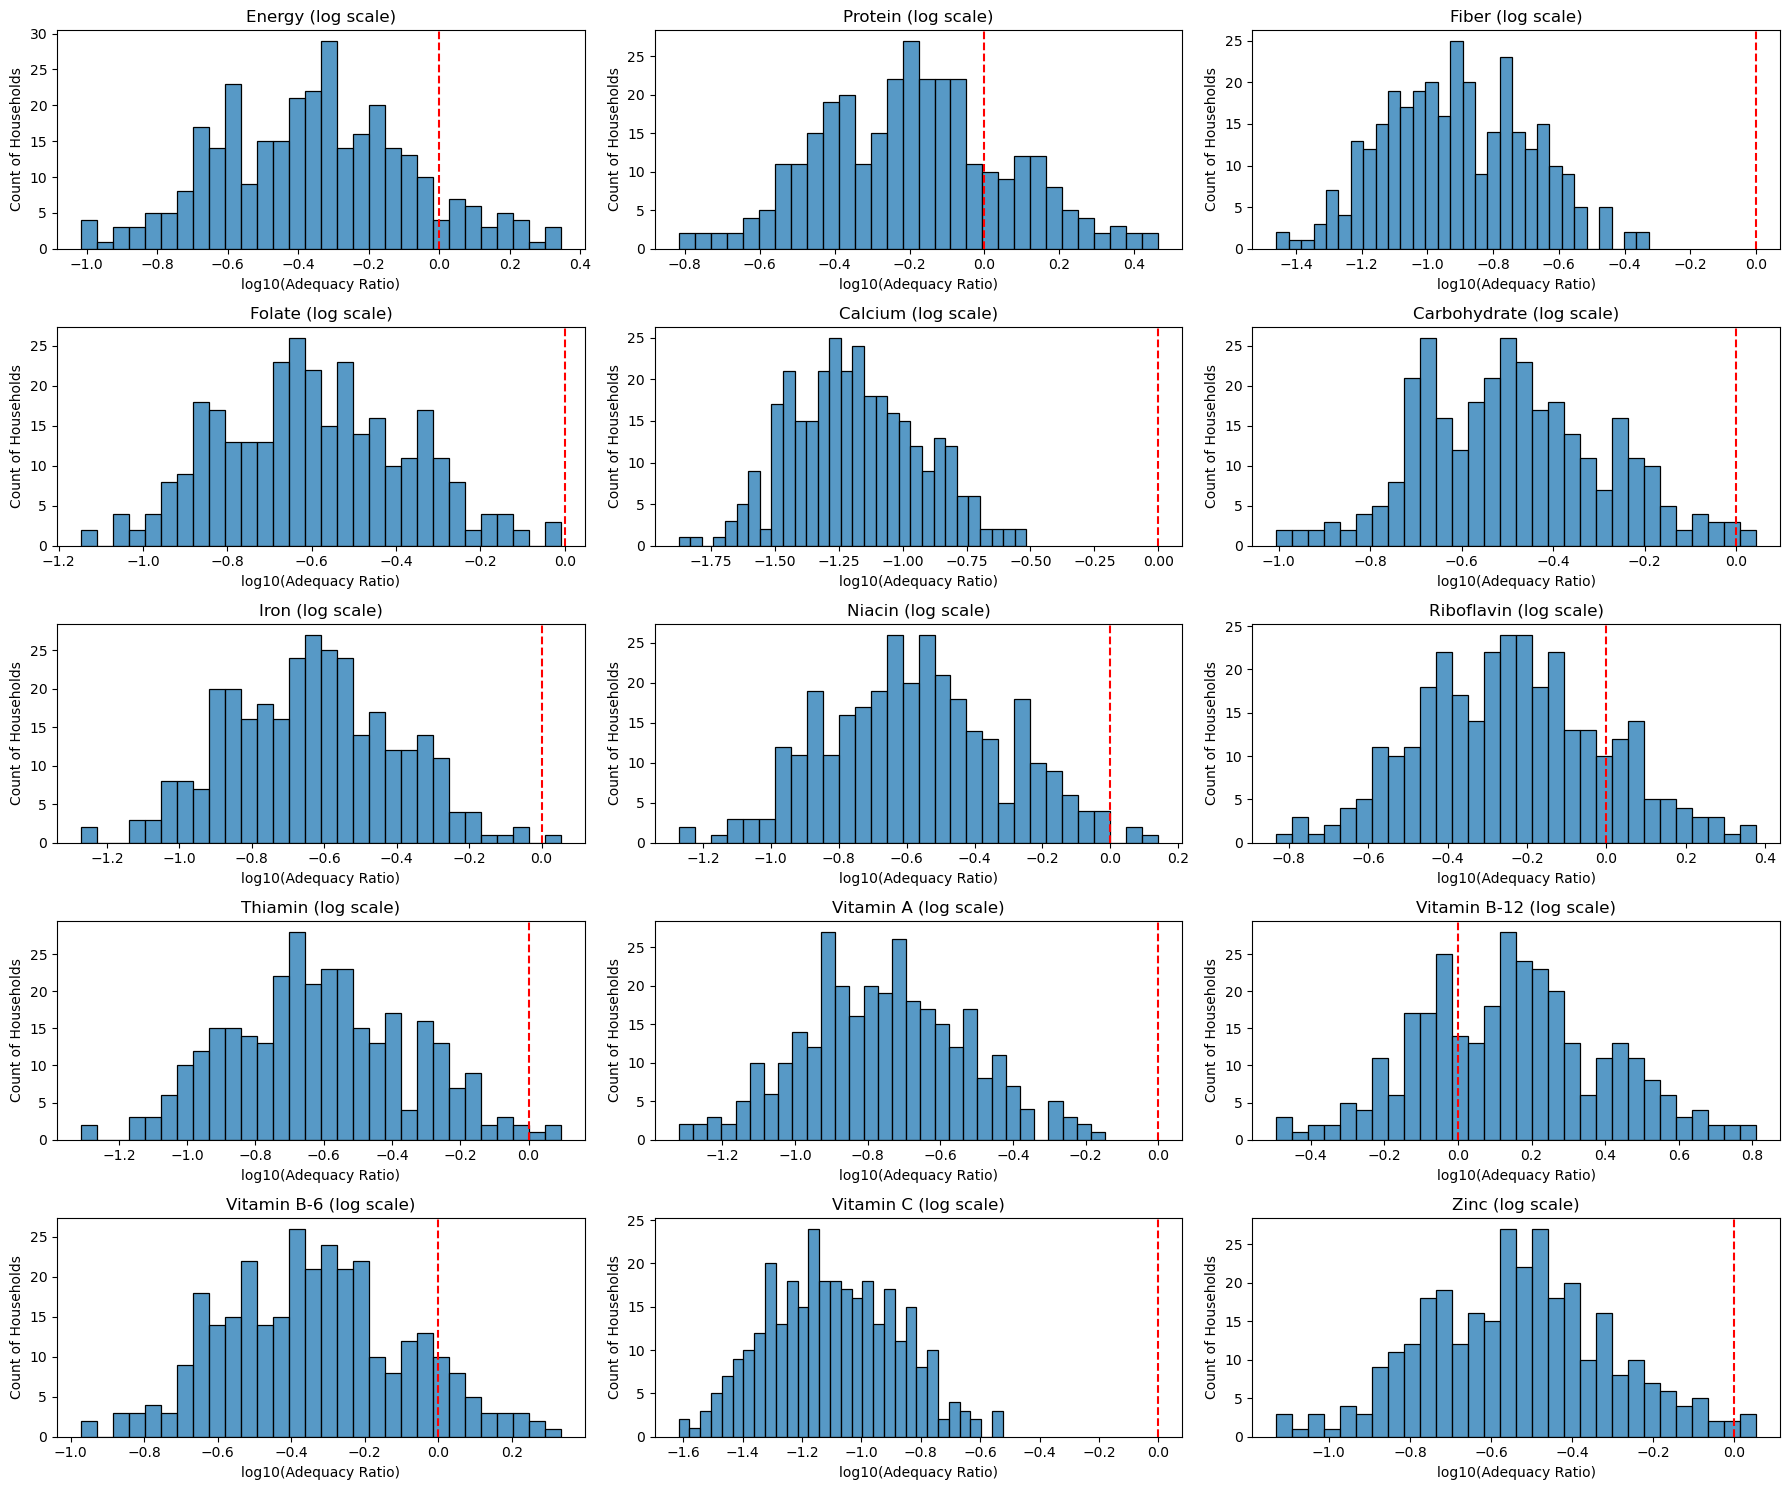

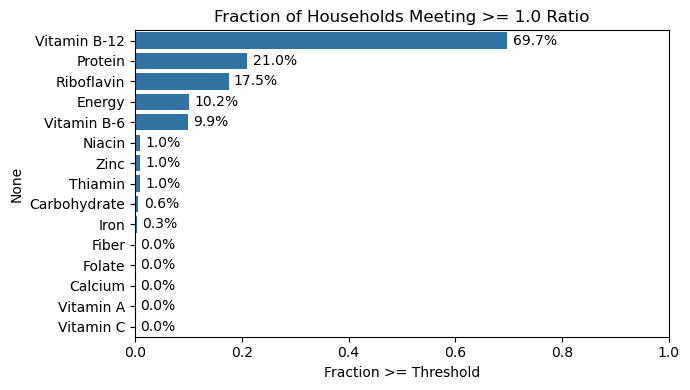

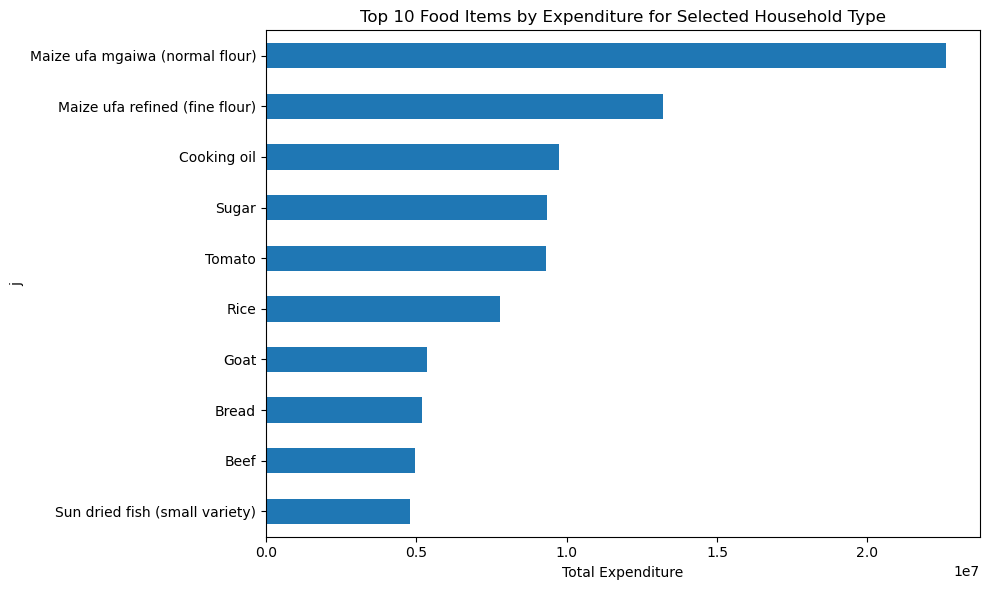

j
Maize ufa mgaiwa (normal flour)    22614580.0
Maize ufa refined (fine flour)     13213775.0
Cooking oil                         9755763.0
Sugar                               9331447.0
Tomato                              9306592.0
Rice                                7797477.0
Goat                                5357271.0
Bread                               5180935.0
Beef                                4957586.0
Sun dried fish (small variety)      4796095.0
dtype: float64

In [223]:
hhc_sub, nut_sub, expenditures_filtered = filter_households(
    hhc,
    nutrient_ratio,
    xhat,
    min_males=0, max_males=1,       
    min_females=2, max_females=100,   
    min_kids=1, max_kids=100        
)
print(f'# households:{hhc_sub.shape}')
avg_expend = expenditures_filtered['total expenditures'].mean().round(2)
avg_expend_usd = (0.0017279606*avg_expend).round(2)
print(f'Average Weekly Food Expenditures: ${avg_expend} (${avg_expend_usd} USD)')
analyze_nutritional_adequacy_subplots_log(nut_sub)
plot_top_foods_by_household(
    hhc,
    expend, 
    min_males=0, max_males=1,       # e.g. 0 adult males
    min_females=2, max_females=100,   # e.g. 1–3 adult females
    min_kids=1, max_kids=100)

#analyze_nutritional_adequacy(nut_sub)

# Changes in nutritional adequacy over time

In [230]:
nutrient_ratio

,,n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,t,m,,,,,,,,,,,,,,,
10101002246,2004-05,North,0.317226,0.344176,0.122321,0.210407,0.054597,0.276591,0.165516,0.177329,0.367091,0.159299,0.106872,0.737308,0.288041,0.069373,0.195434
10101003013,2004-05,North,0.213677,0.265355,0.081655,0.143809,0.030084,0.181100,0.119858,0.124251,0.261348,0.112752,0.075495,0.550083,0.208752,0.052833,0.131278
10101003017,2004-05,North,0.693621,0.829830,0.170831,0.331070,0.071831,0.351300,0.298986,0.350356,0.681877,0.302770,0.199624,1.774968,0.610397,0.124745,0.369032
10101003020,2004-05,North,1.092045,0.965945,0.301179,0.524460,0.162772,0.758622,0.470854,0.507525,0.998185,0.456314,0.284456,2.246979,0.825002,0.155388,0.520011
10101003062,2004-05,North,0.325022,0.368357,0.100165,0.177115,0.037760,0.227791,0.142395,0.156775,0.349439,0.142809,0.105809,0.784125,0.292547,0.068301,0.162569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31202086188,2004-05,Southern,0.324609,0.631772,0.145691,0.302836,0.079226,0.305363,0.239356,0.287618,0.588813,0.274685,0.174388,1.312099,0.478938,0.095875,0.275925
31202086288,2004-05,Southern,0.568176,1.061634,0.244799,0.505301,0.128863,0.502401,0.450112,0.504819,0.991321,0.480468,0.281102,2.280970,0.822415,0.157709,0.460110
31202086289,2004-05,Southern,0.518419,0.863177,0.225420,0.448928,0.151655,0.594143,0.411470,0.448089,0.877739,0.427898,0.251213,1.967660,0.710626,0.122589,0.410203


In [229]:

avg_per_year = nutrient_ratio.groupby('t').mean()
avg_per_year

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
t,,,,,,,,,,,,,,,
2004-05,0.670794,0.963853,0.18752,0.402628,0.113745,0.490129,0.424159,0.419832,0.881099,0.388776,0.265323,2.186789,0.726301,0.119366,0.428614


In [225]:
import pandas as pd
import plotly.express as px

# Reset index and convert 't' to string/categorical
df = avg_per_year.reset_index()
df['t'] = df['t'].astype(str)  # or use: df['t'] = pd.Categorical(df['t'], ordered=True)

# Melt to long format
df_long = df.melt(id_vars='t', var_name='Nutrient', value_name='Adequacy Ratio')

# Create interactive plot with x as categorical
fig = px.line(
    df_long,
    x='t',
    y='Adequacy Ratio',
    color='Nutrient',
    markers=True,
    title='Average Nutrient Adequacy Ratios by Year'
)

fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Adequacy Ratio',
    legend_title='Nutrient',
    hovermode='x unified',
    xaxis=dict(type='category')  # Force x-axis to be discrete
)

fig.show()


NameError: name 'avg_per_year' is not defined

In [95]:
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
import seaborn as sns
import math

def analyze_nutritional_adequacy_subplots_log(
    nut_df,
    adequacy_threshold=1.0,  # We'll draw a vertical line at log10(1.0) = 0
    bins=30,
    n_cols=3
):
    """
    Create subplots of histograms for each nutrient ratio, using log10 scale.
    We drop any rows where a nutrient ratio <= 0 to avoid log(0) or log(negative).
    
    Parameters:
    -----------
    nut_df : pd.DataFrame
        DataFrame of nutrient adequacy ratios, with each column a nutrient.
    adequacy_threshold : float
        We'll add a vertical line at log10(adequacy_threshold).
        e.g. if threshold=1.0, the line is at x=0. 
    bins : int
        Number of histogram bins.
    n_cols : int
        Number of columns of subplots (we auto-calc rows).
    """

    # 1) Filter out rows where any ratio <= 0
    #    (log10 is undefined for non-positive values)
    mask = (nut_df > 0).all(axis=1)
    df_pos = nut_df[mask].copy()
    
    # 2) Decide which columns to plot (skip any columns like 'n' if needed)
    plot_cols = [c for c in df_pos.columns if c not in ["n"]]
    
    # 3) Compute log10 for each plotted nutrient
    for col in plot_cols:
        df_pos["log10_" + col] = np.log10(df_pos[col])

    # 4) Create subplots: N rows x n_cols
    n_rows = math.ceil(len(plot_cols) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 3*n_rows), sharey=False)
    axes = axes.flatten()

    log_threshold = np.log10(adequacy_threshold)

    # 5) For each nutrient column, plot histogram of log10(ratio)
    for i, col in enumerate(plot_cols):
        ax = axes[i]
        sns.histplot(df_pos["log10_" + col], bins=bins, kde=False, ax=ax)
        ax.axvline(log_threshold, color="red", linestyle="--")
        ax.set_title(f"{col} (log scale)")
        ax.set_xlabel("log10(Adequacy Ratio)")
        ax.set_ylabel("Count of Households")

    # Hide extra subplot axes if the # of nutrients isn't a multiple of n_cols
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

     # 3) Compute fraction that meet/exceed threshold
    fraction_meeting = {}
    for col in nut_df.columns:
        if col in ("n",):  # skip non‐ratio columns
            continue
        # fraction of households with ratio >= threshold
        fraction_meeting[col] = (nut_df[col] >= adequacy_threshold).mean()

    # Turn this into a DataFrame for easy plotting
    frac_df = pd.DataFrame.from_dict(fraction_meeting, orient="index", columns=["Fraction >= Threshold"])
    frac_df = frac_df.sort_values("Fraction >= Threshold", ascending=False)

    # Plot bar chart
    plt.figure(figsize=(7, 4))
    sns.barplot(x=frac_df["Fraction >= Threshold"], y=frac_df.index, orient="h")
    plt.title(f"Fraction of Households Meeting >= {adequacy_threshold} Ratio")
    plt.xlim(0, 1)  # fraction from 0 to 1
    for i, val in enumerate(frac_df["Fraction >= Threshold"]):
        plt.text(val + 0.01, i, f"{val:.1%}", va='center')  # label with percentage
    plt.tight_layout()
    plt.show()


# Regional Differences
## Note: lots of nuance lost in splitting into regions. Quick tool to see the range of differences

In [ ]:
hhc

In [ ]:
expend

In [ ]:
import pandas as pd
import plotly.express as px
import json

with open("sn.json") as f:
    senegal_geo = json.load(f)
# Or using geopandas:
gdf = gpd.read_file("sn.json")


# 3) Create the choropleth
#    We'll use an animation slider for nutrient selection. Each "frame" in the slider is a different nutrient.
fig = px.choropleth(
    region_nutrient_df,
    geojson=senegal_geo,
    locations='region',         # Column in region_nutrient_df that matches GeoJSON features' property
    featureidkey='properties.region_name_in_geojson', 
    # ^^^ Adjust to the property name in your geojson that stores the region's name. 
    color='fraction_meeting',
    color_continuous_scale='YlOrRd',
    range_color=(0,1),          # fraction_meeting from 0% to 100% (0-1)
    scope='africa',             # "africa" or use fig.update_geos(...)
    hover_name='region',        # Display region name on hover
    animation_frame='nutrient', # This tells Plotly to create an animation slider for different nutrients
)

# 4) Customize the hover template, layout, etc.
fig.update_traces(
    hovertemplate="<b>%{hovertext}</b><br>" +
                  "Fraction meeting: %{z:.1%}<extra></extra>"
)
fig.update_layout(
    title="Senegal: % of Households Meeting Recommended Nutrient Intake",
    margin={"r":0,"t":50,"l":0,"b":0}
)
fig.update_geos(fitbounds="locations", visible=False)

fig.show()


In [ ]:
def filter_regions(hhc, nutrient_ratio, regions):
    """
    Return rows (households) from hhc and nutrient_ratio
    where the 'm' index level is in the given list of regions.

    Both DataFrames must be MultiIndexed by (i, t, m).
    """

    # 1) Build a Boolean mask selecting only desired regions
    #    We take the 'm' level of the index and check if it is in `regions`.
    mask = hhc.index.get_level_values('m').isin(regions)

    # 2) Apply this mask to both dataframes
    hhc_filtered = hhc.loc[mask].copy()

    # 3) Intersection with nutrient_ratio's index
    #    so we only keep households that exist in BOTH data frames.
    common_idx = hhc_filtered.index.intersection(nutrient_ratio.index)
    hhc_filtered = hhc_filtered.loc[common_idx]
    nutrient_filtered = nutrient_ratio.loc[common_idx]

    return hhc_filtered, nutrient_filtered

    #nutrient_filtered = nutrient_ratio.loc[mask].copy()

    #return hhc_filtered, nutrient_filtered


In [ ]:
hhc.index.get_level_values("m").unique()

In [ ]:
nutrient_ratio

# Urban regions

In [ ]:
hhc_sub, nutrient_sub = filter_regions(hhc, nutrient_ratio, ['dakar'])
analyze_nutritional_adequacy_subplots_log(nutrient_sub)

In [ ]:
hhc_sub.shape

# More Rural Regions 

In [ ]:
hhc_sub, nutrient_sub = filter_regions(hhc, nutrient_ratio, rural_regions)
analyze_nutritional_adequacy_subplots_log(nutrient_sub)



In [ ]:
hhc_sub.shape